# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import shutil
import glob
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42
    
    run_optuna = False
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != CFG.target]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [5]:
mutual_info = mutual_info_classif(X, y, random_state=CFG.seed, discrete_features=True)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Moisture,0.003308
Phosphorous,0.002984
Nitrogen,0.002373
Crop Type,0.002088
Potassium,0.001367
Humidity,0.001015
Temparature,0.000966
Soil Type,0.000617


# Training base models

In [6]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [8]:
lgbm_params = {
    # https://www.kaggle.com/code/patrykszcz/single-lgb-5-folds?scriptVersionId=243298529
    "boosting_type": "gbdt",
    "n_estimators": 10000,
    "learning_rate": 0.06408094783107429,
    "num_leaves": 169,
    "max_depth": 10,
    "min_child_samples": 19,
    "subsample": 0.6420340301820501,
    "colsample_bytree": 0.43403799235854973,
    "reg_alpha": 6.294093849568123,
    "reg_lambda": 5.5559072866866455,
    "random_state": 42,
    "verbosity": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.39736332491996407,
    "learning_rate": 0.008033740989500222,
    "min_child_samples": 29,
    "min_child_weight": 0.6732469853333759,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 89,
    "random_state": 42,
    "reg_alpha": 15.595856670965969,
    "reg_lambda": 51.43625034648377,
    "subsample": 0.07846482736630467,
    "verbose": -1
}

xgb_params = {
    # https://www.kaggle.com/code/patrykszcz/simple-xgb-model-5-fold
    "max_depth": 12,
    "colsample_bytree": 0.467,
    "subsample": 0.86,
    "n_estimators": 10000,
    "learning_rate": 0.03,
    "gamma": 0.26,
    "max_delta_step": 4,
    "reg_alpha": 2.7,
    "reg_lambda": 1.4,
    "early_stopping_rounds": 100,
    "objective": 'multi:softprob',
    "random_state": 13,
    "enable_categorical": True,
}

cb_params = {
    "iterations": 1000,
    "verbose": False
}

In [9]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

## LightGBM (gbdt)

In [10]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[500]	valid_0's multi_logloss: 1.90492
Early stopping, best iteration is:
[606]	valid_0's multi_logloss: 1.90456

--- Fold 1 - MAP@3: 0.349892


Training until validation scores don't improve for 100 rounds
[500]	valid_0's multi_logloss: 1.90402
Early stopping, best iteration is:
[685]	valid_0's multi_logloss: 1.90331

--- Fold 2 - MAP@3: 0.351373


Training until validation scores don't improve for 100 rounds
[500]	valid_0's multi_logloss: 1.90336
Early stopping, best iteration is:
[770]	valid_0's multi_logloss: 1.90277

--- Fold 3 - MAP@3: 0.352069


Training until validation scores don't improve for 100 rounds
[500]	valid_0's multi_logloss: 1.90546
Early stopping, best iteration is:
[601]	valid_0's multi_logloss: 1.90509

--- Fold 4 - MAP@3: 0.350410


Training until validation scores don't improve for 100 rounds
[500]	valid_0's multi_logloss: 1.90447
Early stopping, best iteration is:
[708]	valid

## LightGBM (goss)

In [11]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=500), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[500]	valid_0's multi_logloss: 1.92541
[1000]	valid_0's multi_logloss: 1.91883
[1500]	valid_0's multi_logloss: 1.91493
[2000]	valid_0's multi_logloss: 1.91224
[2500]	valid_0's multi_logloss: 1.91033
[3000]	valid_0's multi_logloss: 1.90903
[3500]	valid_0's multi_logloss: 1.90805
[4000]	valid_0's multi_logloss: 1.90729
[4500]	valid_0's multi_logloss: 1.90677
[5000]	valid_0's multi_logloss: 1.90639
Early stopping, best iteration is:
[5137]	valid_0's multi_logloss: 1.90631

--- Fold 1 - MAP@3: 0.347417


Training until validation scores don't improve for 100 rounds
[500]	valid_0's multi_logloss: 1.92551
[1000]	valid_0's multi_logloss: 1.91882
[1500]	valid_0's multi_logloss: 1.91485
[2000]	valid_0's multi_logloss: 1.91207
[2500]	valid_0's multi_logloss: 1.91002
[3000]	valid_0's multi_logloss: 1.90852
[3500]	valid_0's multi_logloss: 1.90743
[4000]	valid_0's multi_logloss: 1.90653
[4500]	valid_0's multi_log

## XGBoost

In [12]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 500
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94559
[500]	validation_0-mlogloss:1.90524
[1000]	validation_0-mlogloss:1.90174
[1136]	validation_0-mlogloss:1.90178

--- Fold 1 - MAP@3: 0.353274


[0]	validation_0-mlogloss:1.94560
[500]	validation_0-mlogloss:1.90474
[1000]	validation_0-mlogloss:1.90070
[1166]	validation_0-mlogloss:1.90067

--- Fold 2 - MAP@3: 0.353812


[0]	validation_0-mlogloss:1.94559
[500]	validation_0-mlogloss:1.90389
[1000]	validation_0-mlogloss:1.89974
[1171]	validation_0-mlogloss:1.89968

--- Fold 3 - MAP@3: 0.355259


[0]	validation_0-mlogloss:1.94560
[500]	validation_0-mlogloss:1.90517
[1000]	validation_0-mlogloss:1.90136
[1137]	validation_0-mlogloss:1.90134

--- Fold 4 - MAP@3: 0.354348


[0]	validation_0-mlogloss:1.94560
[500]	validation_0-mlogloss:1.90467
[1000]	validation_0-mlogloss:1.90071
[1149]	validation_0-mlogloss:1.90075

--- Fold 5 - MAP@3: 0.354466



------ Overall MAP@3: 0.354232 | Average MAP@3: 0.354232 ± 0.000666


## CatBoost

In [13]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)

fit_args = {
    "verbose": 500,
    "early_stopping_rounds": 100,
    "use_best_model": True,
    "cat_features": cat_cols
}

oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, fit_args)

Training CatBoostClassifier

Learning rate set to 0.122713
0:	learn: 1.9447850	test: 1.9447950	best: 1.9447950 (0)	total: 2.51s	remaining: 41m 46s
500:	learn: 1.9076049	test: 1.9268559	best: 1.9268559 (500)	total: 18m 25s	remaining: 18m 21s
999:	learn: 1.8863363	test: 1.9242531	best: 1.9242459 (998)	total: 36m 58s	remaining: 0us

bestTest = 1.92424585
bestIteration = 998

Shrink model to first 999 iterations.

--- Fold 1 - MAP@3: 0.322499


Learning rate set to 0.122713
0:	learn: 1.9447349	test: 1.9448158	best: 1.9448158 (0)	total: 2.48s	remaining: 41m 21s
500:	learn: 1.9075093	test: 1.9261465	best: 1.9261465 (500)	total: 18m 12s	remaining: 18m 8s
999:	learn: 1.8860844	test: 1.9235214	best: 1.9235164 (995)	total: 36m 29s	remaining: 0us

bestTest = 1.923516375
bestIteration = 995

Shrink model to first 996 iterations.

--- Fold 2 - MAP@3: 0.323412


Learning rate set to 0.122713
0:	learn: 1.9447516	test: 1.9448138	best: 1.9448138 (0)	total: 2.46s	remaining: 40m 54s
500:	learn: 1.9072262

## AutoGluon

In [14]:
oof_preds_files = glob.glob(f'/kaggle/input/s05e06-fertilizer-optimization-autogluon/*_oof_pred_probs_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s05e06-fertilizer-optimization-autogluon/*_test_pred_probs_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_scores = []
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]
    score = map3(y_val, y_preds)
    ag_scores.append(score)
    
oof_pred_probs["AutoGluon"], test_pred_probs["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

# Ensembling with LogisticRegression

In [15]:
X = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [16]:
joblib.dump(X, "oof_pred_probs.pkl")
joblib.dump(X_test, "test_pred_probs.pkl")

['test_pred_probs.pkl']

In [17]:
def objective(trial):
    solver_penalty_options = [
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('lbfgs', 'l2'),
        ('lbfgs', None)
    ]
    solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
    params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'C': trial.suggest_float('C', 0, 10),
        'tol': trial.suggest_float('tol', 1e-7, 1e-2),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': solver,
        'penalty': penalty
    }
    
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)


if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=250, n_jobs=-1)
    best_params = study.best_params
    
    solver, penalty = best_params['solver_penalty']
    lr_params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'solver': solver,
        'penalty': penalty,
        'fit_intercept': best_params['fit_intercept'],
        'class_weight': best_params['class_weight'],
        'C': best_params['C'],
        'tol': best_params['tol']
    }
else:
    lr_params = {
        'random_state': CFG.seed,
        'max_iter': 500
    }

In [18]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500
}


In [19]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)

_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.353407
--- Fold 2 - MAP@3: 0.354832
--- Fold 3 - MAP@3: 0.355811
--- Fold 4 - MAP@3: 0.354239
--- Fold 5 - MAP@3: 0.354617

------ Overall MAP@3: 0.354581 | Average MAP@3: 0.354581 ± 0.000784


In [20]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:, -3:][:, ::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [21]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,10-26-26 DAP 20-20
1,750001,17-17-17 20-20 10-26-26
2,750002,20-20 28-28 17-17-17
3,750003,14-35-14 DAP 10-26-26
4,750004,20-20 Urea 28-28


# Results

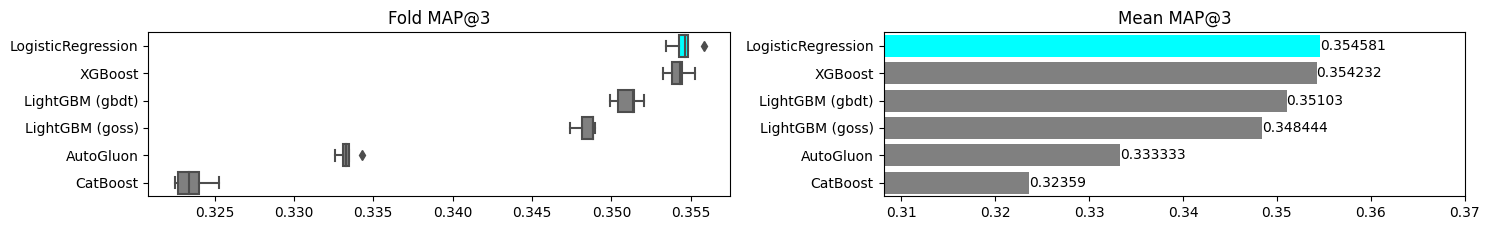

In [22]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [23]:
shutil.rmtree("catboost_info", ignore_errors=True)